In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import imgkit
import matplotlib.font_manager as fm
import plotly.figure_factory as ff
from IPython.display import display, HTML
warnings.simplefilter(
    action='ignore', category=display)

In [2]:
# circuits = pd.read_csv("./rawdata/circuits.csv")
# constructor_results = pd.read_csv("./rawdata/constructor_results.csv")
# constructor_standings = pd.read_csv("./rawdata/constructor_standings.csv")
# constructors = pd.read_csv("./rawdata/constructors.csv")
# driver_standings = pd.read_csv("./rawdata/driver_standings.csv")
# drivers = pd.read_csv("./rawdata/drivers.csv")
# lap_times = pd.read_csv("./rawdata/lap_times.csv")
# pit_stops = pd.read_csv("./rawdata/pit_stops.csv")
# qualifying = pd.read_csv("./rawdata/qualifying.csv")
# races = pd.read_csv("./rawdata/races.csv")
# results = pd.read_csv("./rawdata/results.csv")
# seasons = pd.read_csv("./rawdata/seasons.csv")
# sprint_results = pd.read_csv("./rawdata/sprint_results.csv")
# status = pd.read_csv("./rawdata/status.csv")


# TEAM COLORS
TEAM_COLORS = {
    "mercedes": "#27F4D2",
    "red_bull": "#3671C6",
    "ferrari": "#E80020",
    "mclaren": "#FF8000",
    "alpine": "#00A1E8",
    "rb": "#6692FF",
    "aston_martin": "#229971",
    "williams": "#1868DB",
    "sauber": "#52E252",
    "haas": "#B6BABD",
}

TABLE_COLORS = {
    "header": "#e90d18",
    "fastest": "#a528c2",
    "sub": "#f0cc38",
    "gray": "#dddddd",
    "black": "#000000"
}

# Data Preprocessing


In [3]:
# # drop unneccessary columns
# drivers.drop(columns='url')
# circuits.drop(columns='url')
# constructors.drop(columns='url')
# # add fullname column in 'drivers'
# drivers["fullname"] = drivers["forename"] + " " + drivers["surname"]

# # convert milliseconds to seconds


# def convert_to_seconds(val):
#     try:
#         return int(val) / 6000
#     except ValueError:
#         return val


# drivers.to_csv("./data/drivers.csv", index=False)
# results.to_csv("./data/results.csv", index=False)
# sprint_results.to_csv("./data/sprint_results.csv", index=False)

# Data Manipulation

## Race and Championship Results

In [4]:
class F1Query:

    class NoResultError(Exception):
        def __init__(self, exact=True):
            self.exact = exact
            if exact:
                super().__init__("No result found. Enter valid keywords")
            else:
                super().__init__(
                    "No result found. Try 'exact=False' or 'F1Query.setExact(False)'.")

    class MultipleResultError(Exception):
        def __init__(self, keyword):
            self.keyword = keyword
            super().__init__(
                f"Multiple result found with keyword[{keyword}]. Try more complicated keywords")

    def __init__(self):
        self.circuits = pd.read_csv("./data/circuits.csv", index_col=False)
        self.constructor_results = pd.read_csv(
            "./data/constructor_results.csv", index_col=False)
        self.constructor_standings = pd.read_csv(
            "./data/constructor_standings.csv", index_col=False)
        self.constructors = pd.read_csv(
            "./data/constructors.csv", index_col=False)
        self.driver_standings = pd.read_csv(
            "./data/driver_standings.csv", index_col=False)
        self.drivers = pd.read_csv("./data/drivers.csv",  index_col=False)
        self.lap_times = pd.read_csv("./data/lap_times.csv",  index_col=False)
        self.pit_stops = pd.read_csv("./data/pit_stops.csv",  index_col=False)
        self.qualifying = pd.read_csv(
            "./data/qualifying.csv",  index_col=False)
        self.races = pd.read_csv("./data/races.csv",  index_col=False)
        self.results = pd.read_csv("./data/results.csv",  index_col=False)
        self.seasons = pd.read_csv("./data/seasons.csv",  index_col=False)
        self.sprint_results = pd.read_csv(
            "./data/sprint_results.csv",  index_col=False)
        self.status = pd.read_csv("./data/status.csv",  index_col=False)

        self.__exact = False
        self.__verbose = True

        self._font_init()

    def _font_init(self):
        display(HTML("<style>table {font-family: 'Times New Roman';}</style>"))

    def setExact(self, exactness):
        assert type(exactness) == bool
        self.__exact = exactness

    def setVerbose(self, verboseness):
        assert type(verboseness) == bool
        self.__verbose = verboseness

    def getCircuitByName(self, circuitName: str, exact=None) -> pd.DataFrame:
        if exact is None:
            exact = self.__exact
        circuitName = circuitName.title()
        circuitQuery = self.circuits.query(
            "name == @circuitName") if exact else self.circuits.query(
            "name.str.contains(@circuitName, case=False) or circuitRef.str.contains(@circuitName, case=False)")
        if len(circuitQuery) == 0:
            raise self.NoResultError(exact)
        else:
            return circuitQuery

    def getCircuitByCountry(self, country: str, exact=None) -> pd.DataFrame:
        if exact is None:
            exact = self.__exact
        country = country.title()
        circuitQuery = self.circuits.query(
            "country == @country") if exact else circuits.query(
            "country.str.contains(@country, case=False)")
        if len(circuitQuery) == 0:
            raise self.NoResultError(exact)
        else:
            return circuitQuery

    def getCircuitByKeyword(self, keyword: str, exact=None) -> pd.DataFrame:
        keyword = keyword.title()
        if exact is None:
            exact = self.__exact
        circuitQuery = []

        if exact:
            circuitQuery = self.circuits.query(
                "name == @keyword or country == @keyword or location == @keyword")
        else:
            circuitQuery = self.circuits.query(
                "name.str.contains(@keyword, case=False) or country.str.contains(@keyword, case=False) or location.str.contains(@keyword, case=False) or circuitRef.str.contains(@keyword, case=False)")

        if len(circuitQuery) == 0:
            raise self.NoResultError(exact)
        else:
            return circuitQuery

    def getRacesByKeyword(self, keyword: str, exact=None) -> pd.DataFrame:
        if exact is None:
            exact = self.__exact
        circuitIds = list(self.getCircuitByKeyword(
            keyword, exact)["circuitId"])
        raceQuery = self.races.query("circuitId in @circuitIds")
        if len(raceQuery) == 0:
            raise self.NoResultError(exact)
        return raceQuery

    def getRacesByYear(self, year: int) -> pd.DataFrame:
        query = self.races.query("year == @year")
        if len(query) == 0:
            raise self.NoResultError()
        return query

    def getRaceIdByYearKeyword(self, year: int, keyword: str, exact=None) -> int:
        if exact is None:
            exact = self.__exact
        raceQuery = self.getRacesByKeyword(
            keyword, exact).query("year == @year")

        if len(raceQuery) == 0:
            raise self.NoResultError(exact)
        elif len(raceQuery) > 1:
            raise self.MultipleResultError(keyword)
        else:
            return raceQuery.iloc[0].raceId

    def getRaceIdByYearRound(self, year: int, round: int) -> int:
        race = self.races.query("year == @year and round == @round")
        if len(race) == 0:
            raise self.NoResultError()
        return race.iloc[0].raceId

    def getDriverIdByNumber(self, driverNumber) -> int:
        driverQuery = self.drivers.query("number == @driverNumber")
        if len(driverQuery) == 0:
            self.NoResultError()
        return driverQuery.iloc[0].driverId

    def getDriverByName(self, driverName: str) -> pd.DataFrame:
        driverName = driverName.title()
        driverQuery = self.drivers.query(
            "fullname.str.contains(@driverName, case=False) or driverRef.str.contains(@driverName, case=False)")
        if len(driverQuery) == 0:
            self.NoResultError()
        return driverQuery

    def getRaceResultById(self, raceId) -> pd.DataFrame:
        raceResults = self.results.query("raceId == @raceId")
        if len(raceResults) == 0:
            raise self.NoResultError()
        return raceResults

    def getRaceResultByKeyword(self, keyword, exact=None) -> pd.DataFrame:
        if exact is None:
            exact = self.__exact
        races = self.getCircuitByKeyword(keyword, exact)

    def getDriverStandingsOfYear(self, year) -> pd.DataFrame:
        rounds = len(self.getRacesByYear(year))

        driverStandings = pd.DataFrame(columns=["driverId"])
        for round in range(1, rounds + 1):
            raceId = self.getRaceIdByYearRound(year, round)
            driverStanding = self.driver_standings.query("raceId == @raceId")
            driverStanding = driverStanding[["driverId", "position"]]
            driverStanding.rename(
                columns={"position": f"R{round}"}, inplace=True)
            driverStandings = pd.merge(
                driverStandings, driverStanding, how="outer", on=["driverId"])
        driverStandings.fillna(len(driverStandings), inplace=True)
        driverStandings.sort_values(by=f"R{rounds}", inplace=True)
        driverStandings = driverStandings.astype(int)
        return driverStandings

    def getConstructorStandingsOfYear(self, year) -> pd.DataFrame:
        rounds = len(self.getRacesByYear(year))

        constructorStandings = pd.DataFrame(columns=["constructorId"])
        for round in range(1, rounds + 1):
            raceId = self.getRaceIdByYearRound(year, round)
            constructorStanding = self.constructor_standings.query(
                "raceId == @raceId")
            constructorStanding = constructorStanding[[
                "constructorId", "position"]]
            constructorStanding.rename(
                columns={"position": f"R{round}"}, inplace=True)
            constructorStandings = pd.merge(
                constructorStandings, constructorStanding, how="outer", on=["constructorId"])
        constructorStandings.fillna(len(constructorStandings), inplace=True)
        constructorStandings.sort_values(by=f"R{rounds}", inplace=True)
        constructorStandings = constructorStandings.astype(int)
        return constructorStandings

# Visualization 

In [180]:
class F1Visualizer:
    def __init__(self):
        self.colors = TEAM_COLORS
        self.font = "Formula1"
        self.query = F1Query()

        # self.driverDict = dict(
        # zip(self.query.drivers["driverId"], self.query.drivers["code"] if self.query.drivers["code"] != '\\N' else self.query.drivers["name"]))
        self.driverDict = dict()
        for row in self.query.drivers.itertuples(index=False):
            code = row.code
            ref = row.surname
            id = row.driverId
            self.driverDict[id] = ref if code == "\\N" else code
        self.constructorDict = dict(
            zip(self.query.constructors["constructorId"], zip(self.query.constructors["name"], self.query.constructors["constructorRef"])))
        self.status = dict(
            zip(self.query.status["statusId"], self.query.status["status"]))
        self.HEADER_STYLE = [
            {'selector': 'th', 'props': [
                ('font-weight', 'Display-Bold'), ('color', TABLE_COLORS['header']), ('background-color', TABLE_COLORS['gray'])]},
            # Italicize all cells
            # {'selector': 'td', 'props': [('color', TABLE_COLORS['black'])]}
        ]
        self.exportDir = "./tables"
        self._font_init()

    def _font_init(self):
        display(HTML("<style>table {font-family: 'Formula1';}</style>"))

    # Replace IDs to readable strings
    def _addReadables(self, df):
        try:
            df['DRIVER'] = list(
                map(lambda x: self.driverDict[x], df['driverId']))
        except KeyError:
            pass
        try:
            df['TEAM'] = list(
                map(lambda x: self.constructorDict[x][0], df['constructorId']))
        except KeyError:
            pass
        try:
            df['STATUS'] = list(map(lambda x: self.status[x], df['statusId']))
        except KeyError:
            pass
        return df

    def _teamColor(self, row, index=1):
        color = TEAM_COLORS.get(self.constructorDict.get(
            row.constructorId)[1], "black")
        return [''] * index + [f'color: {color}'] * 2 + [''] * (len(row) - index - 2)

    def _podiumColor(self, val):
        color = ""
        try:
            val = int(val)
        except ValueError:
            pass

        if val == 1:
            color = f"{TABLE_COLORS['fastest']}; font-weight: bold"
        elif val == 2 or val == 3:
            color = f"{TABLE_COLORS['sub']}; font-weight: bold"
        elif val == "R" or val == "N":
            color = f"{TABLE_COLORS['header']}; font-weight: bold"
        else:
            color = ""
        return f'color: {color}'

    def _statusColor(self, val):
        color = ""
        if val == "Finished":
            color = ""
        elif "Lap" in val:
            color = TABLE_COLORS['sub']
        else:
            color = TABLE_COLORS['header']
        return f'color: {color}'

    def _deltaColor(self, val):
        color = ""
        if val == "-":
            color = ""
        elif int(val) > 0:
            color = TABLE_COLORS['sub']
        else:
            color = TABLE_COLORS['fastest']
        return f'color: {color}'

    def _minColor(self, s):
        s = s.replace("-", chr(0x10ffff))
        minVal = s.min()
        print(minVal)
        return [f"color: {TABLE_COLORS['fastest']}; font-weight: bold" if v == minVal else '' for v in s]

    def _posDelta(self, row):
        if row['positionText'] in 'NR':
            return "-"
        else:
            try:
                int(row['grid'])
            except ValueError:
                return "-"
            delta = int(row['positionText']) - int(row['grid'])
            if delta > 0:
                return "+" + str(delta)
            elif delta == 0:
                return "-"
            else:
                return str(delta)

    def _htmlCss(self, html):
        return f"""
        <html>
        <head>
        <style>
            body {{ font-family: "Formula1"; }}
        </style>
        </head>
        <body>
        {html}
        </body>
        </html>
        """

    def exportDataFrame(self, styledDf, exportName):
        exportPath = f"{self.exportDir}/{exportName}"
        html = styledDf.to_html()
        with open(f"{exportPath}.html", "w") as f:
            f.write(self._htmlCss(html))
        imgkit.from_file(f"{exportPath}.html",
                         f"{exportPath}.png")

    def showRaceResult(self, raceId, export=False):
        # get race results
        raceResult = self.query.getRaceResultById(raceId).copy()
        raceResult = self._addReadables(raceResult)

        # drop unneccesarry columns and replace special values
        raceResult.astype(str)
        raceResult.drop(columns=['resultId', 'raceId', 'milliseconds',
                        'fastestLap', 'rank', 'fastestLapSpeed', 'position', 'positionOrder', 'number'], inplace=True)
        raceResult['points'] = raceResult.points.astype(int)
        raceResult['time'].replace("\\N", "-", inplace=True)
        raceResult['fastestLapTime'].replace("\\N", "-", inplace=True)
        raceResult['∆POS'] = raceResult.apply(self._posDelta, axis=1)
        # rename and reindex
        raceResult.rename(columns={
            "positionText": "POS",
            "grid": "GRID",
            "points": "PTS",
            "time": "TIME",
            "fastestLapTime": "FASTEST LAP",
            "laps": "LAPS"
        }, inplace=True)

        raceResult = raceResult[["POS", "DRIVER", "TEAM", "LAPS",
                                 "TIME", "PTS", "FASTEST LAP", "GRID", "∆POS", "STATUS", "driverId", "constructorId", "statusId"]]

        # styling
        styledResult = raceResult.style.hide(  # hide columns
            ["driverId", "constructorId", "statusId"], axis=1
        ).hide(
            # hide index column
        ).set_table_styles(
            self.HEADER_STYLE  # set header style
        ).applymap(
            self._podiumColor, subset=['POS']
        ).applymap(
            self._statusColor, subset=['STATUS']
        ).applymap(
            self._deltaColor, subset=['∆POS']
        ).apply(
            self._teamColor, axis=1
        ).apply(
            self._minColor, subset=['FASTEST LAP']
        )

        if export:
            self.exportDataFrame(styledResult, f"Race{raceId}_Results")

        return styledResult

    def _randomColor(self):
        return f"#{hex(np.random.randint(1, int('0xffffff', base=16) + 1))[2:].zfill(6)}"

    def showDriverStandingGraph(self, year, export=False):
        standing = self.query.getDriverStandingsOfYear(year)
        standing = self._addReadables(standing)
        standing.set_index("DRIVER", inplace=True)
        standing.drop(columns="driverId", inplace=True)

        # Path to your installed font (update this!)
        font_path = "/Users/yooseungkim/Library/Fonts/Formula1-Regular.otf"
        # Create a font object
        custom_font = fm.FontProperties(fname=font_path)

        plt.figure(figsize=(12, 7))
        plt.rcParams["font.family"] = custom_font.get_name()
        plt.rcParams["font.weight"] = "light"
        sns.set_context("notebook")
        sns.lineplot(data=standing.T, marker="o")
        plt.xlabel("ROUND")
        plt.ylabel("POSITION")
        plt.yticks(range(1, len(standing) + 1, 2))
        plt.gca().invert_yaxis()
        plt.title(f"F1 {year} DRIVER STANDINGS", fontproperties=custom_font)
        plt.legend(title="DRIVERS", loc="upper center",
                   bbox_to_anchor=(0.5, -0.15), ncol=int(len(standing) / 2))

        # for col in standing:
        #     x_last = standing[col].iloc[-1]  # Last X value
        #     y_last = standing[col].iloc[-1]      # Last Y value
        #     plt.text(x_last + 0.2, y_last, col, fontsize=12,
        #              verticalalignment='center')
        if export:
            plt.savefig(f"{self.exportDir}/{year} Driver Standings.png",
                        dpi=500, bbox_inches="tight")

        plt.show()

    def showConstructorStandingGraph(self, year, export=False):
        standing = self.query.getConstructorStandingsOfYear(year)
        standing = self._addReadables(standing)
        standing.set_index("TEAM", inplace=True)
        standing.drop(columns="constructorId", inplace=True)

        # Path to your installed font (update this!)
        font_path = "/Users/yooseungkim/Library/Fonts/Formula1-Regular.otf"
        # Create a font object
        custom_font = fm.FontProperties(fname=font_path)

        colorMap = dict()
        for k, v in self.constructorDict.items():
            colorMap[v[0]] = TEAM_COLORS.get(v[1], self._randomColor())

        plt.figure(figsize=(12, 7))
        sns.set_theme(style="darkgrid")
        plt.rcParams["font.family"] = custom_font.get_name()
        plt.rcParams["font.weight"] = "light"
        sns.set_context("notebook")
        sns.lineplot(data=standing.T, marker="o", palette=colorMap)
        plt.xlabel("ROUND")
        plt.ylabel("POSITION")
        plt.yticks(range(1, len(standing) + 1))
        plt.gca().invert_yaxis()
        plt.title(f"F1 {year} CONSTRUCTOR STANDINGS",
                  fontproperties=custom_font)
        plt.legend(title="CONSTRUCTORS", loc="upper center",
                   bbox_to_anchor=(0.5, -0.15), ncol=int(len(standing) / 2))

        # for col in standing:
        #     x_last = standing[col].iloc[-1]  # Last X value
        #     y_last = standing[col].iloc[-1]      # Last Y value
        #     plt.text(x_last + 0.2, y_last, col, fontsize=12,
        #              verticalalignment='center')
        if export:
            plt.savefig(f"{self.exportDir}/{year} Constructor Standings.png",
                        dpi=500, bbox_inches="tight")
        plt.show()

In [181]:

Visualizer = F1Visualizer()

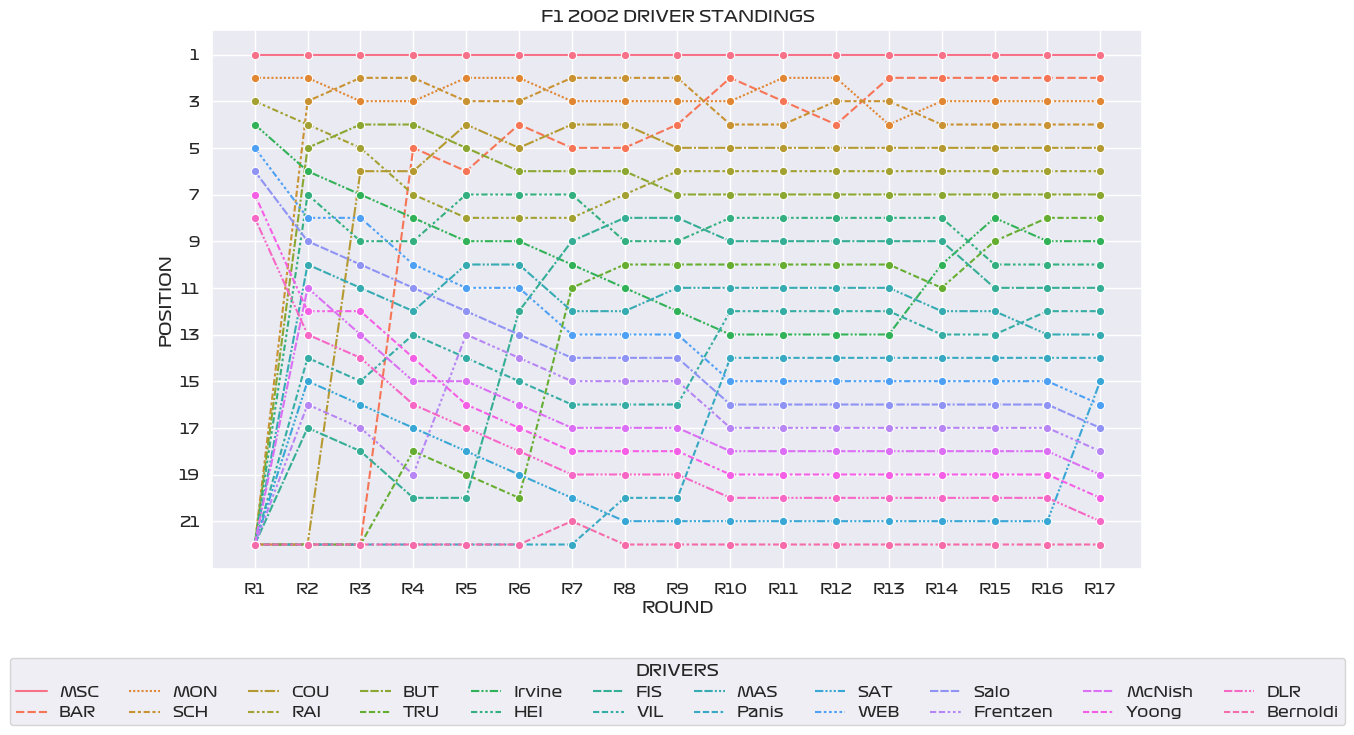

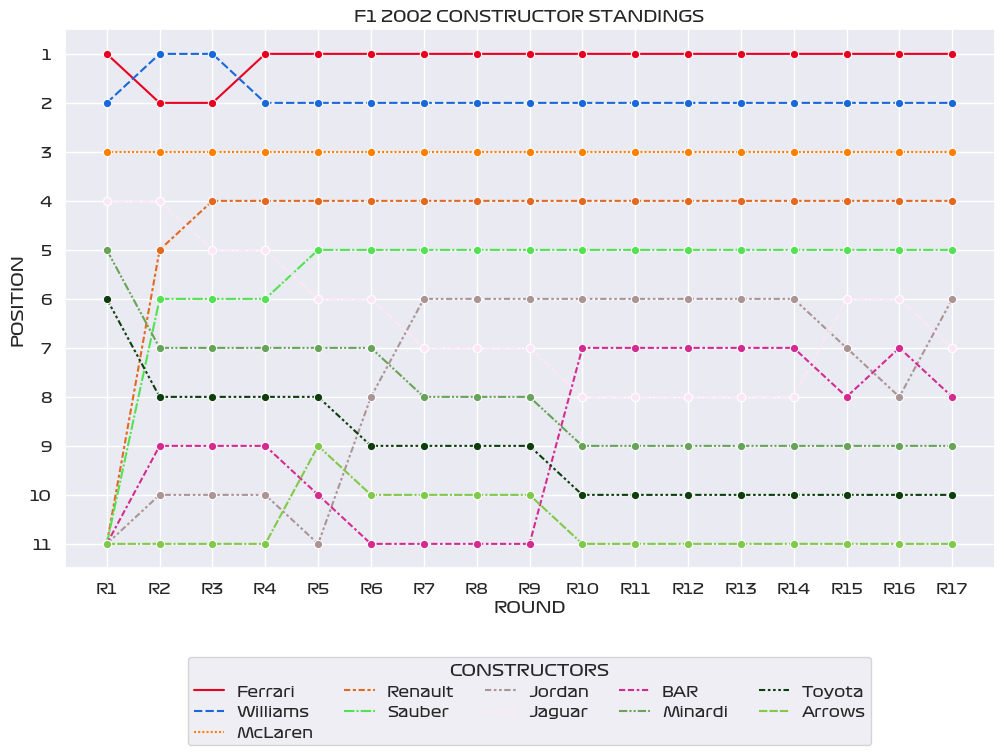

In [182]:
Visualizer.showDriverStandingGraph(2002)
Visualizer.showConstructorStandingGraph(2002)

In [183]:
Visualizer.query.getDriverStandingsOfYear(2002)

,driverId,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16,R17
7,30,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
19,22,22,22,22,5,6,4,5,5,4,2,3,4,2,2,2,2,2
6,31,2,2,3,3,2,2,3,3,3,3,2,2,4,3,3,3,3
16,23,22,3,2,2,3,3,2,2,2,4,4,3,3,4,4,4,4
17,14,22,22,6,6,4,5,4,4,5,5,5,5,5,5,5,5,5
5,8,3,4,5,7,8,8,8,7,6,6,6,6,6,6,6,6,6
15,18,22,5,4,4,5,6,6,6,7,7,7,7,7,7,7,7,7
18,15,22,22,22,18,19,20,11,10,10,10,10,10,10,11,9,8,8
4,56,4,6,7,8,9,9,10,11,12,13,13,13,13,10,8,9,9
14,2,22,7,9,9,7,7,7,9,9,8,8,8,8,8,10,10,10


In [147]:
Visualizer.query.drivers.query("code== \\N")

SyntaxError: unexpected character after line continuation character (<unknown>, line 1)

In [148]:
Visualizer.query.drivers.value_counts()

driverId  driverRef      number  code  forename  surname   dob         nationality    url                                                         fullname      
1         hamilton       44      HAM   Lewis     Hamilton  1985-01-07  British        http://en.wikipedia.org/wiki/Lewis_Hamilton                 Lewis Hamilton    1
567       orey           \N      \N    Fritz     d'Orey    1938-03-25  Brazilian      http://en.wikipedia.org/wiki/Fritz_d%27Orey                 Fritz d'Orey      1
569       ashdown        \N      \N    Peter     Ashdown   1934-10-16  British        http://en.wikipedia.org/wiki/Peter_Ashdown                  Peter Ashdown     1
570       bill_moss      \N      \N    Bill      Moss      1933-09-04  British        http://en.wikipedia.org/wiki/Bill_Moss_(racing_driver)      Bill Moss         1
571       dennis_taylor  \N      \N    Dennis    Taylor    1921-06-12  British        http://en.wikipedia.org/wiki/Dennis_Taylor_(racing_driver)  Dennis Taylor     1
         